In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn import model_selection

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
import tarfile
import urllib

dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
data_path = os.path.join(dir_path, "data")
original_file_path = os.path.join(data_path, "hr_attrition.csv")

In [4]:
df = pd.read_csv(original_file_path)

Custom functions from the data cleaning/transformation notebook

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### returns DataFrame with standardized numerical variables and encoded categorical variables
def transform(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # giving the original values for education field and job role to be used later, if needed
    inverse_edu_job = data[lab_vars]
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded

    
    # standardizing numerical variables
    num_pipeline = Pipeline([('scaler', StandardScaler())])
    num_std = num_pipeline.fit_transform(data[df_num])
    data[df_num] = num_std
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data, inverse_edu_job


### returns DataFrame with non-standardized numerical variables and encoded categorical variables
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [6]:
df_enc = transform_encoding(df)
df_std, inverse_array = transform(df)
df_enc.head()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1.0,1102,1,1.0,1,1,1.0,94,...,6,4,0,5,0,1,0,0,1,1
1,49,0,2.0,279,8,0.0,1,2,2.0,61,...,10,7,1,7,1,0,1,1,0,0
2,37,1,1.0,1373,2,1.0,4,4,3.0,92,...,0,0,0,0,1,0,1,0,1,1
3,33,0,2.0,1392,3,3.0,1,5,3.0,56,...,8,7,3,0,1,0,0,1,0,1
4,27,0,1.0,591,2,0.0,3,7,0.0,40,...,2,2,2,2,1,0,1,1,0,0


#### Testing for Correlation with Target

In [7]:
corr = df_enc.corr()['Attrition'].sort_values()
print("Top 10 highest correlations:")
print(corr.tail(10))
print("-"*25)

print("Top 10 lowest correlations:")
print(corr.head(10))

Top 10 highest correlations:
EducationField          0.020289
Gender_Male             0.037651
NumCompaniesWorked      0.048371
JobRole                 0.068069
DistanceFromHome        0.080935
Department_Sales        0.083978
BusinessTravel          0.131544
MaritalStatus_Single    0.181020
OverTime_Yes            0.253038
Attrition               1.000000
Name: Attrition, dtype: float64
-------------------------
Top 10 lowest correlations:
TotalWorkingYears      -0.187486
YearsInCurrentRole     -0.172973
JobLevel               -0.167773
YearsAtCompany         -0.165175
YearsWithCurrManager   -0.162652
Age                    -0.161395
MonthlyIncome          -0.158067
StockOptionLevel       -0.141431
JobInvolvement         -0.128859
JobSatisfaction        -0.108815
Name: Attrition, dtype: float64


Some correlation between the attrition variable and a few of the variables present in the dataset, but all with an absolute value less than 0.26, so nothing too concerning.

In [8]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

## Information Leakage

Attempting to identify possible information leakage (information that is updated after an employee leaves) <br>
**Note:** Using intuition to choose the features to look at here

In [9]:
df_enc[df_enc['Attrition'] == 1][['Attrition', 'BusinessTravel', 'DailyRate', 'JobLevel', 'NumCompaniesWorked', 'StockOptionLevel', 'YearsInCurrentRole', 'YearsWithCurrManager']].describe()

,Attrition,BusinessTravel,DailyRate,JobLevel,NumCompaniesWorked,StockOptionLevel,YearsInCurrentRole,YearsWithCurrManager
count,232.0,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,1.0,1.245690,758.314655,0.590517,2.935345,0.525862,2.728448,2.737069
std,0.0,0.538539,401.553596,0.882978,2.667773,0.862506,2.940899,3.071275
min,1.0,0.000000,103.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,409.500000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,713.500000,0.000000,1.000000,0.000000,2.000000,2.000000
75%,1.0,2.000000,1094.000000,1.000000,5.000000,1.000000,4.000000,4.000000
max,1.0,2.000000,1496.000000,4.000000,9.000000,3.000000,15.000000,14.000000


In [10]:
df_enc[df_enc['Attrition'] == 0][['Attrition', 'BusinessTravel', 'DailyRate', 'JobLevel', 'NumCompaniesWorked', 'StockOptionLevel', 'YearsInCurrentRole', 'YearsWithCurrManager']].describe()

,Attrition,BusinessTravel,DailyRate,JobLevel,NumCompaniesWorked,StockOptionLevel,YearsInCurrentRole,YearsWithCurrManager
count,1185.0,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000
mean,0.0,1.056540,814.209283,1.061603,2.610127,0.853165,4.393249,4.275949
std,0.0,0.525701,403.499334,1.050460,2.449814,0.845522,3.610788,3.527015
min,0.0,0.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,480.000000,0.000000,1.000000,0.000000,2.000000,2.000000
50%,0.0,1.000000,819.000000,1.000000,2.000000,1.000000,3.000000,3.000000
75%,0.0,1.000000,1176.000000,2.000000,4.000000,1.000000,7.000000,7.000000
max,0.0,2.000000,1499.000000,4.000000,9.000000,3.000000,18.000000,17.000000


I'm assuming that the features are not updated after an employee leaves, but are reflective of their time prior. `JobLevel` and `StockOptionLevel` are the categories which make me most suspicious, but I would imagine that differences between the two average levels has more to do with the types of employees that leave most often (lower level).

## Train-Test Split

In [11]:
X_enc = df_enc.drop('Attrition', axis = 'columns')
y_enc = df_enc['Attrition']

X_std = df_std.drop('Attrition', axis = 'columns')
y_std = df_std['Attrition']

In [12]:
from sklearn.model_selection import train_test_split
X_enc_train, X_enc_val_test, y_enc_train, y_enc_val_test = train_test_split(X_enc, y_enc, test_size = 0.3, random_state = 6)
X_std_train, X_std_val_test, y_std_train, y_std_val_test = train_test_split(X_std, y_std, test_size = 0.3, random_state = 6)

## Test-Validation Split

In [13]:
X_enc_val, X_enc_test, y_enc_val, y_enc_test = train_test_split(X_enc_val_test, y_enc_val_test, test_size = 0.5, random_state = 6)
X_std_val, X_std_test, y_std_val, y_std_test = train_test_split(X_std_val_test, y_std_val_test, test_size = 0.5, random_state = 6)

## Baseline Model

#### Dummy Classifier

In [14]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_enc_train, y_enc_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


DummyClassifier()

In [15]:
dummy_clf.score(X_enc_val, y_enc_val)  # accuracy

0.7136150234741784

In [16]:
from sklearn import metrics
metrics.precision_score(y_enc_val, dummy_clf.predict(X_enc_val))

0.3125

## Evaluation Metrics

In [17]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

#### Classification Score<br>
Evaluates model on training and validation sets

In [19]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))

        print("End of validation Result\n")

#### Classification Metrics<br>
Gives classification model metric scores

In [20]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.1, max_iter = 500, random_state = 6)
clf.fit(X_std_train, y_std_train)

LogisticRegression(C=0.1, max_iter=500, random_state=6)

Validation Result:

Accuracy: 0.8826



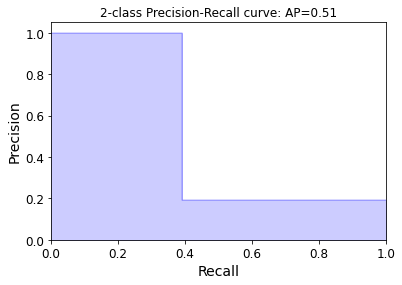

roc auc score: 0.6951219512195121



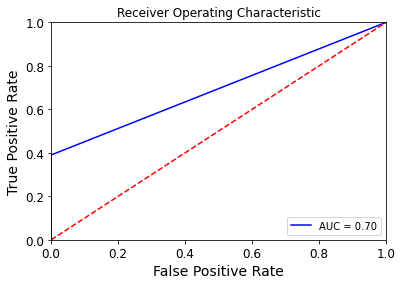

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       172
           1       1.00      0.39      0.56        41

    accuracy                           0.88       213
   macro avg       0.94      0.70      0.75       213
weighted avg       0.90      0.88      0.86       213


Confusion Matrix: 
 [[172   0]
 [ 25  16]]

End of validation Result



In [22]:
clf_score(clf, X_std_train, y_std_train, X_std_val, y_std_val, train = False)

#### Over-Sampling with SMOTE<br>
There are many fewer employees that have left, classes should be rebalanced.

In [23]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_std_train, y_std_train)

In [26]:
clf_smote = LogisticRegression(C=0.001, random_state=42)
clf_smote.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.001, random_state=42)

Validation Result:

Accuracy: 0.6714



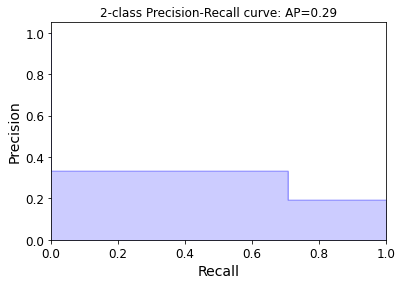

roc auc score: 0.6850538854225752



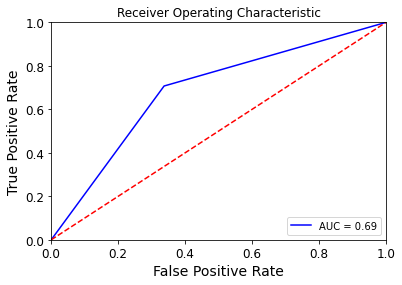

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.66      0.77       172
           1       0.33      0.71      0.45        41

    accuracy                           0.67       213
   macro avg       0.62      0.69      0.61       213
weighted avg       0.79      0.67      0.71       213


Confusion Matrix: 
 [[114  58]
 [ 12  29]]

End of validation Result



In [27]:
clf_score(clf_smote, X_train_sm, y_train_sm, X_std_val, y_std_val, train = False)

### Random Forest

In [28]:
sm = SMOTE(random_state = 6)
X_enc_train_sm, y_enc_train_sm = sm.fit_sample(X_enc_train, y_enc_train)

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

RandomForestClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8357



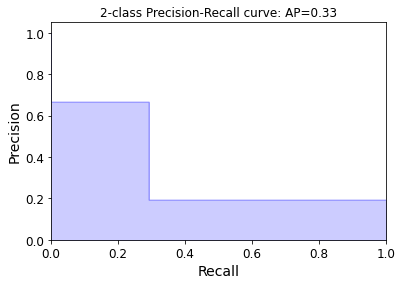

roc auc score: 0.628899602949518



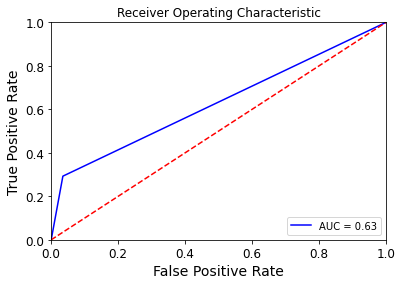

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.90       172
           1       0.67      0.29      0.41        41

    accuracy                           0.84       213
   macro avg       0.76      0.63      0.66       213
weighted avg       0.82      0.84      0.81       213


Confusion Matrix: 
 [[166   6]
 [ 29  12]]

End of validation Result



In [30]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

This is much better than logistic regression<br>
Trying without SMOTE, too

In [31]:
clf = RandomForestClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train, y_enc_train)

RandomForestClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8263



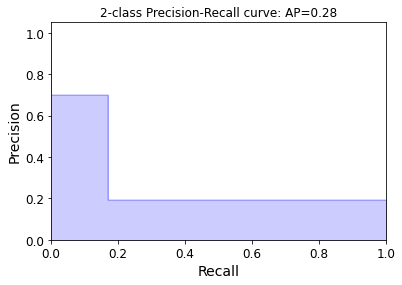

roc auc score: 0.5766449234259784



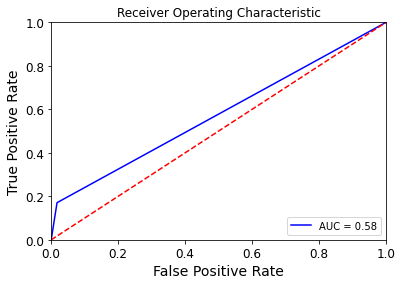

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.98      0.90       172
           1       0.70      0.17      0.27        41

    accuracy                           0.83       213
   macro avg       0.77      0.58      0.59       213
weighted avg       0.81      0.83      0.78       213


Confusion Matrix: 
 [[169   3]
 [ 34   7]]

End of validation Result



In [32]:
clf_score(clf, X_enc_train, y_enc_train, X_enc_val, y_enc_val, train = False)

### Feature Importance Using RF

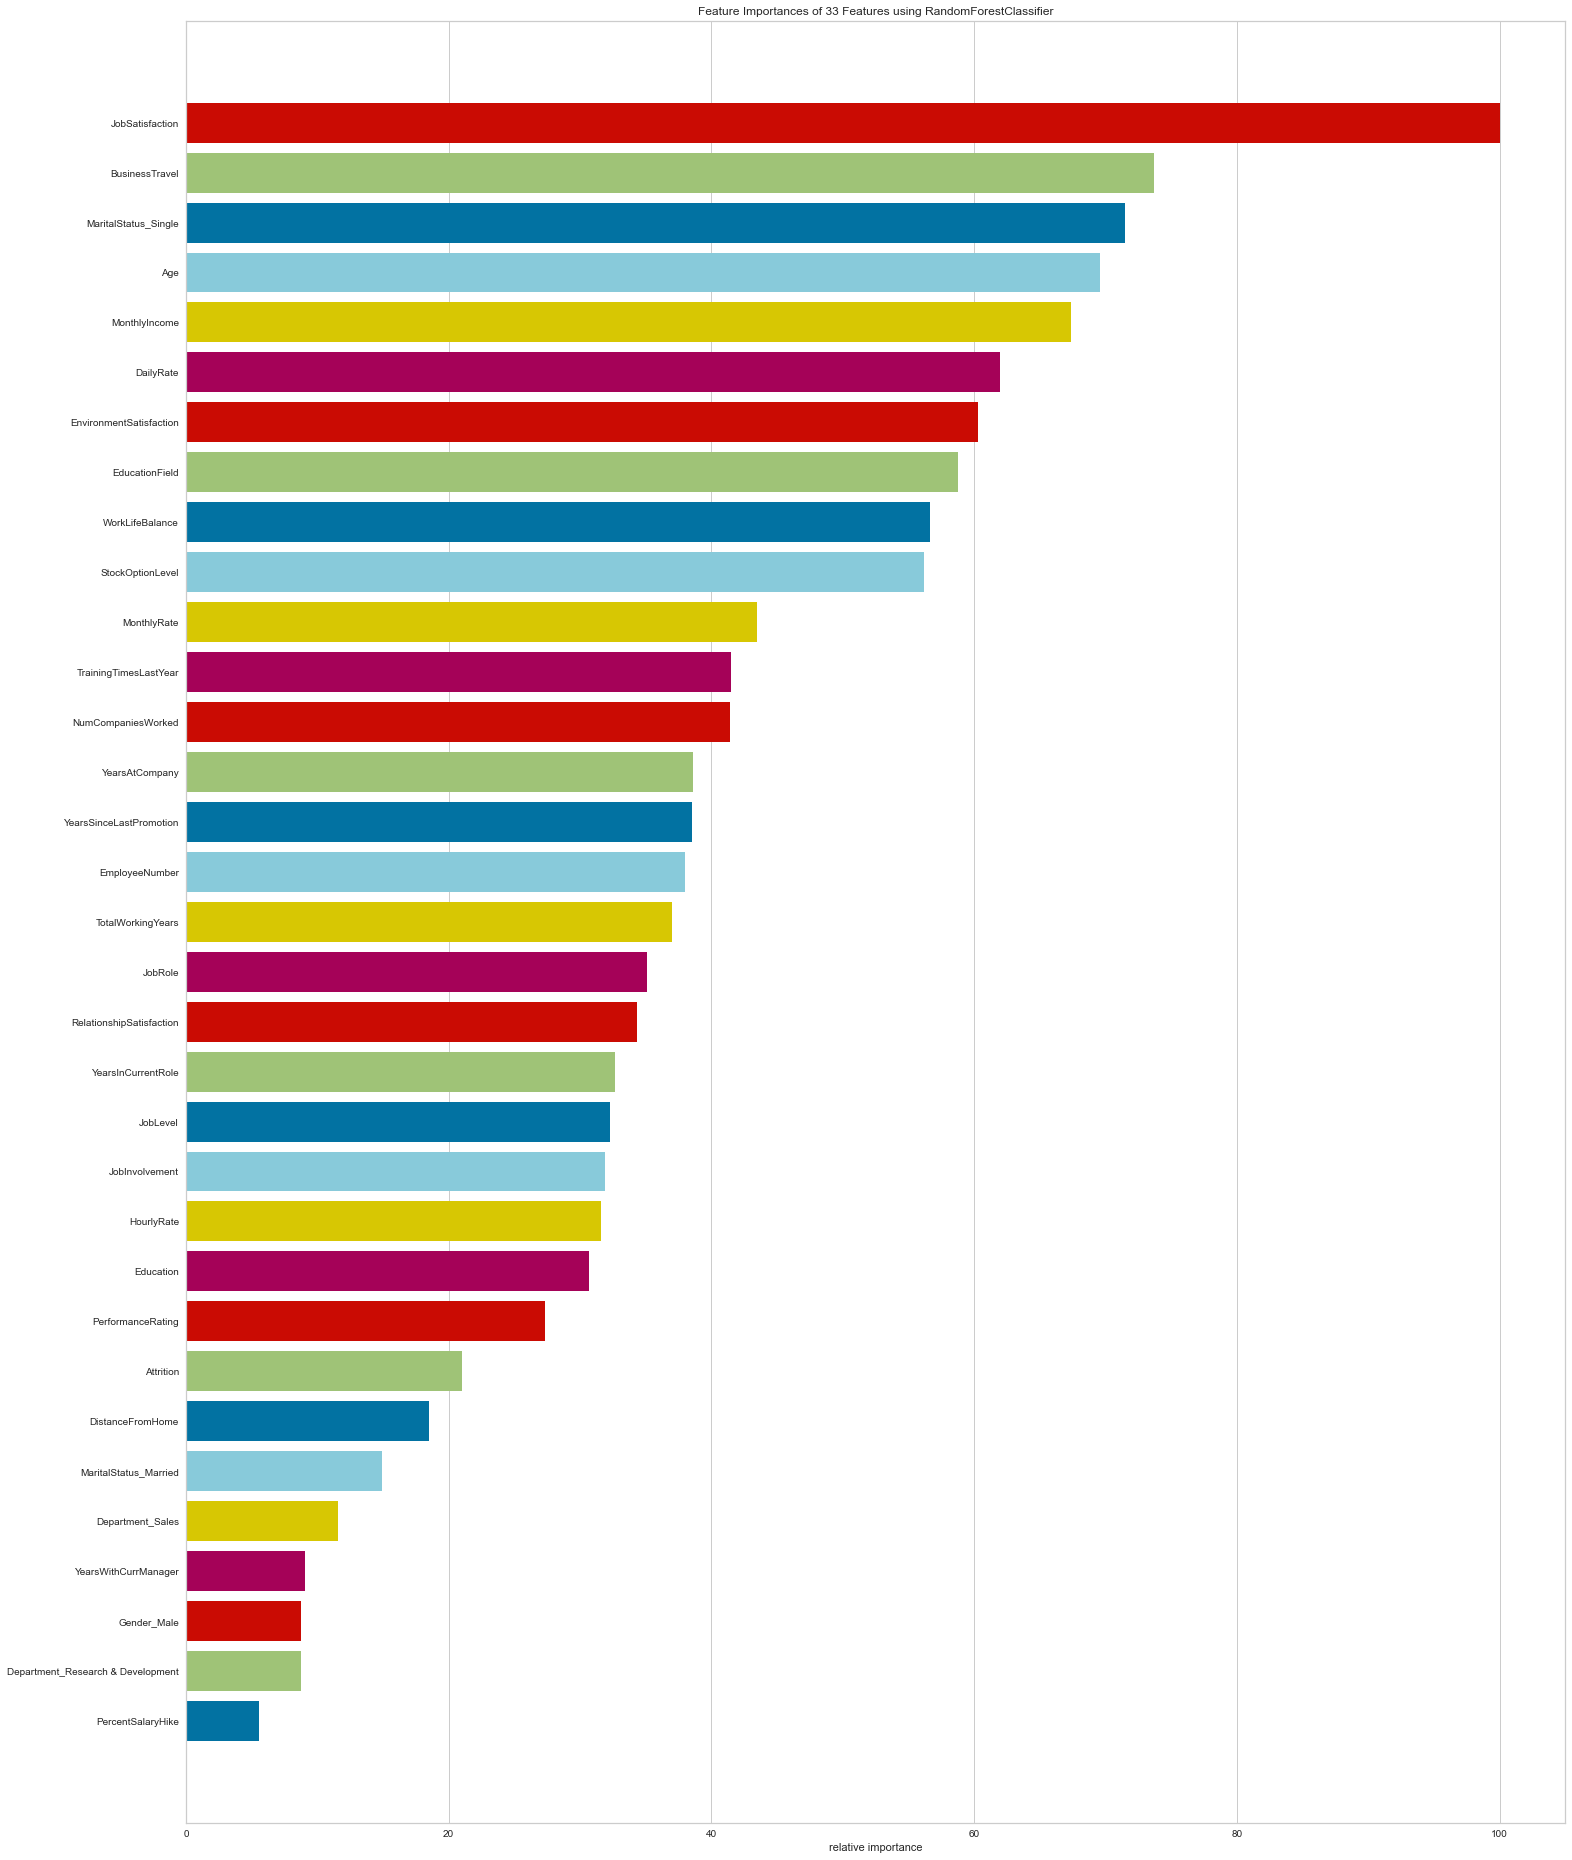

<AxesSubplot:title={'center':'Feature Importances of 33 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [33]:
from yellowbrick.model_selection import FeatureImportances

fig = plt.figure(figsize=(22, 26))
viz = FeatureImportances(clf, labels=df_enc.columns)
viz.fit(X_enc_train, y_enc_train)
viz.poof()

Predictably, `JobSatisfaction` is the most important factor. 

## LightGBM LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier

In [48]:
clf = LGBMClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

LGBMClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8545



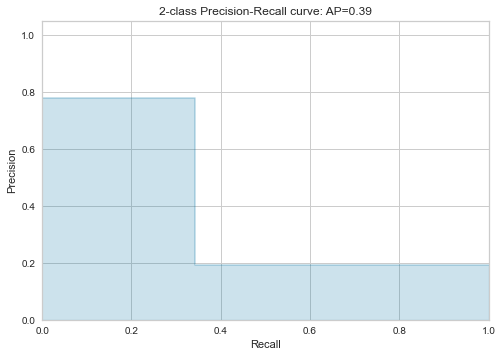

roc auc score: 0.659103800340329



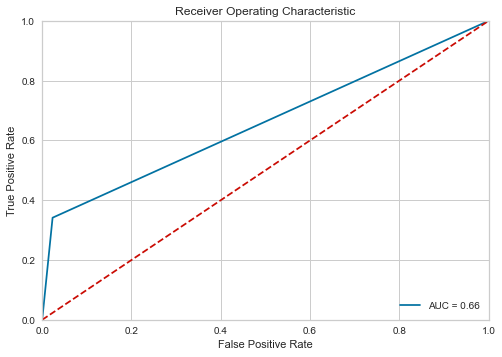

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       172
           1       0.78      0.34      0.47        41

    accuracy                           0.85       213
   macro avg       0.82      0.66      0.70       213
weighted avg       0.85      0.85      0.83       213


Confusion Matrix: 
 [[168   4]
 [ 27  14]]

End of validation Result



In [49]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

In [38]:
clf = LGBMClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train, y_enc_train)

LGBMClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8404



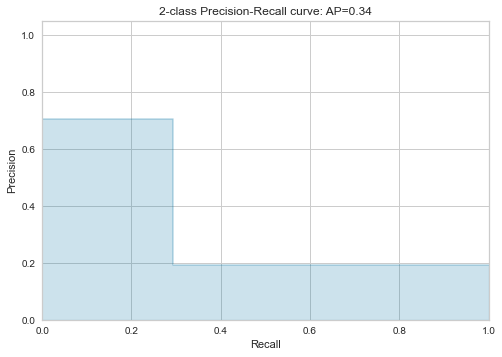

roc auc score: 0.6318065796937039



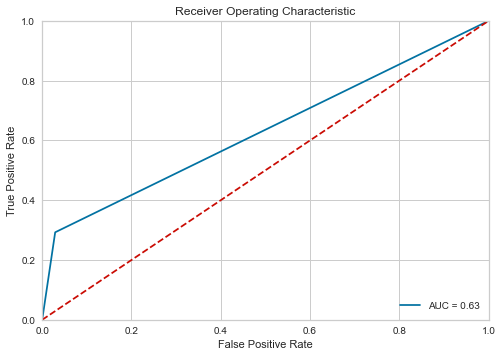

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       172
           1       0.71      0.29      0.41        41

    accuracy                           0.84       213
   macro avg       0.78      0.63      0.66       213
weighted avg       0.82      0.84      0.81       213


Confusion Matrix: 
 [[167   5]
 [ 29  12]]

End of validation Result



In [39]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

### Compare to sklearn GradientBoostingClassifier

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
clf = GradientBoostingClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

GradientBoostingClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8310



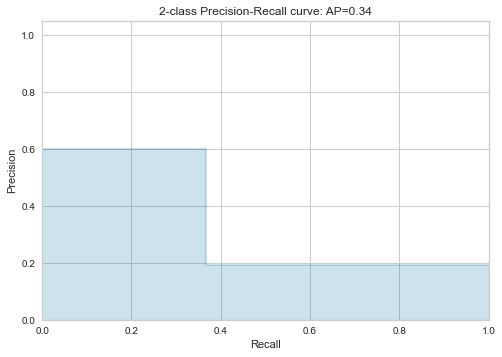

roc auc score: 0.6538570618264322



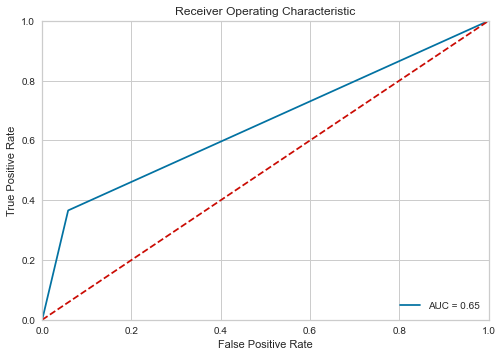

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       172
           1       0.60      0.37      0.45        41

    accuracy                           0.83       213
   macro avg       0.73      0.65      0.68       213
weighted avg       0.81      0.83      0.81       213


Confusion Matrix: 
 [[162  10]
 [ 26  15]]

End of validation Result



In [52]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

Marginally worse than LGBMClassifier, interestingly.

## XGBoost

In [53]:
import xgboost as xgb

In [55]:
clf = xgb.XGBClassifier(random_state = 6)
clf.fit(X_enc_train, y_enc_train)

[14:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=6,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Validation Result:

Accuracy: 0.8404



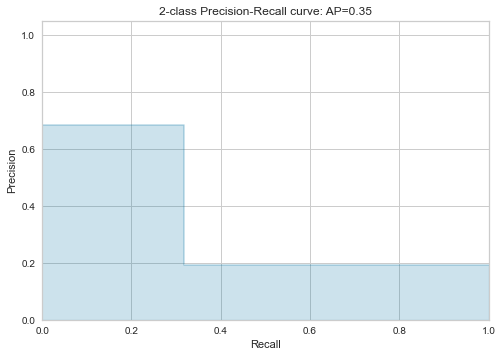

roc auc score: 0.6410947249007375



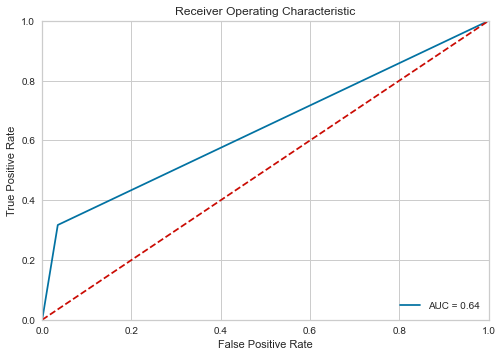

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       172
           1       0.68      0.32      0.43        41

    accuracy                           0.84       213
   macro avg       0.77      0.64      0.67       213
weighted avg       0.82      0.84      0.82       213


Confusion Matrix: 
 [[166   6]
 [ 28  13]]

End of validation Result



In [56]:
clf_score(clf, X_enc_train, y_enc_train, X_enc_val, y_enc_val, train = False)

## AdaBoost

In [63]:
from sklearn.ensemble import AdaBoostClassifier

In [64]:
clf = AdaBoostClassifier(n_estimators = 100, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

AdaBoostClassifier(n_estimators=100, random_state=6)

Validation Result:

Accuracy: 0.8498



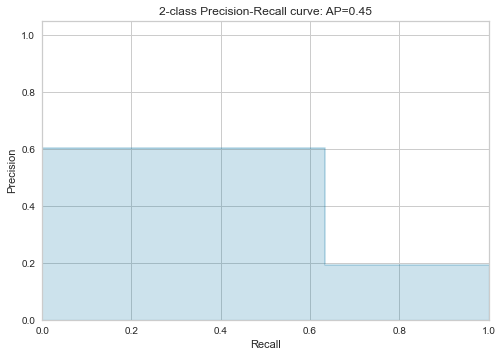

roc auc score: 0.7676545660805446



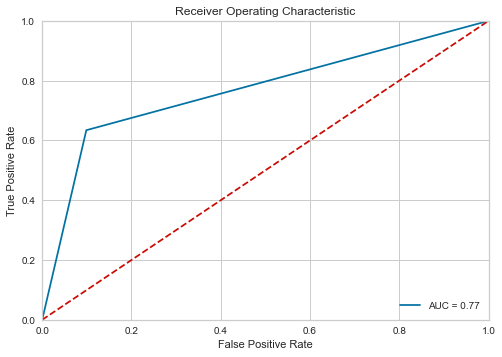

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       172
           1       0.60      0.63      0.62        41

    accuracy                           0.85       213
   macro avg       0.76      0.77      0.76       213
weighted avg       0.85      0.85      0.85       213


Confusion Matrix: 
 [[155  17]
 [ 15  26]]

End of validation Result



In [65]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

In [71]:
from mlxtend.classifier import (
    StackingClassifier, 
)
clfs = [
    x() for x in [
        LogisticRegression,
        RandomForestClassifier,
        GradientBoostingClassifier
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(n_splits=10, random_state=42)
s = model_selection.cross_val_score(stack, X_enc, y_enc, scoring="roc_auc", cv=kfold)
print(f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

StackingClassifier  AUC: 0.662  STD: 0.06


## Preliminary Results

After initial testing, the best models appeared to be the LGBMClassifier and AdaBoostClassifier. Some hyperparameter tuning with these models can be done to improve performance.

### LGBMClassifier Randomized Grid Search

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

In [102]:
param_distribs = {
        'n_estimators': randint(low = 1, high = 150)
    }

lgbm = LGBMClassifier(random_state = 6)
rnd_search = RandomizedSearchCV(lgbm, param_distributions = param_distribs,
                                n_iter = 100, cv = 5, scoring = 'neg_mean_squared_error', random_state = 6)
rnd_search.fit(X_enc, y_enc)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=6), n_iter=100,
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe476bc11d0>},
                   random_state=6, scoring='neg_mean_squared_error')

In [103]:
rnd_search.best_estimator_

LGBMClassifier(n_estimators=44, random_state=6)

In [110]:
clf_best = LGBMClassifier(max_depth=-1, n_estimators=40, random_state=6)
clf_best.fit(X_enc_train_sm, y_enc_train_sm)

LGBMClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8545



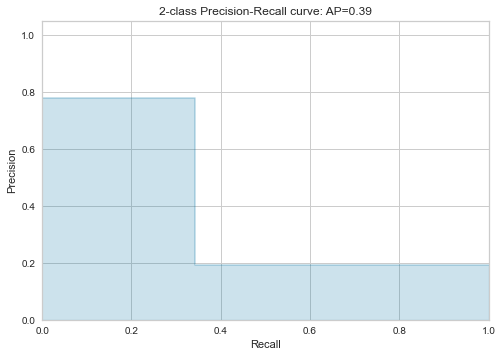

roc auc score: 0.659103800340329



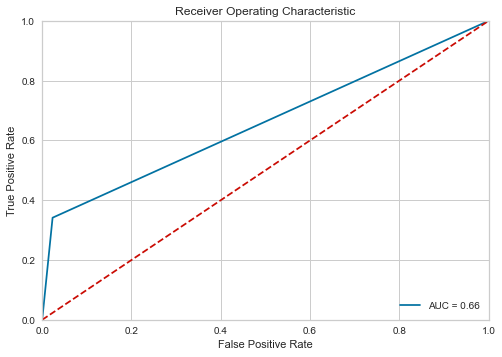

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       172
           1       0.78      0.34      0.47        41

    accuracy                           0.85       213
   macro avg       0.82      0.66      0.70       213
weighted avg       0.85      0.85      0.83       213


Confusion Matrix: 
 [[168   4]
 [ 27  14]]

End of validation Result



In [111]:
clf_score(clf_best, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

### AdaBoostClassifier Randomized Grid Search

In [118]:
params = {
    'n_estimators': randint(low = 30, high = 250),
    'learning_rate': [random.random()]
}
ada = AdaBoostClassifier(random_state = 6)
rnd_search = RandomizedSearchCV(ada, param_distributions = params, n_iter = 100, scoring = 'neg_mean_squared_error', random_state = 6)

In [119]:
rnd_search.fit(X_enc, y_enc)

RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=6), n_iter=100,
                   param_distributions={'learning_rate': [0.8332399582939854],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4770cb550>},
                   random_state=6, scoring='neg_mean_squared_error')

In [121]:
rnd_search.best_estimator_

AdaBoostClassifier(learning_rate=0.8332399582939854, n_estimators=58,
                   random_state=6)

In [122]:
ada_best = AdaBoostClassifier(learning_rate=0.8332399582939854, n_estimators=58, random_state=6)
ada_best.fit(X_enc_train_sm, y_enc_train_sm)

AdaBoostClassifier(learning_rate=0.8332399582939854, n_estimators=58,
                   random_state=6)

Validation Result:

Accuracy: 0.8263



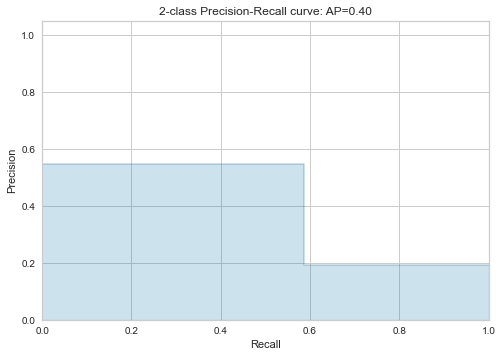

roc auc score: 0.7345433919455474



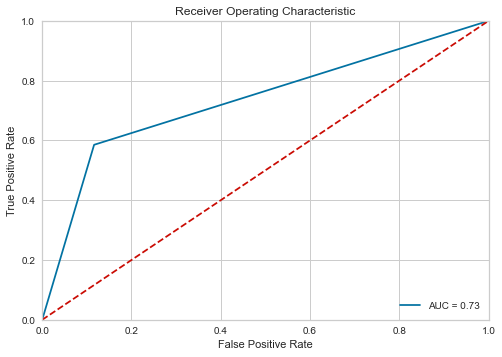

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       172
           1       0.55      0.59      0.56        41

    accuracy                           0.83       213
   macro avg       0.72      0.73      0.73       213
weighted avg       0.83      0.83      0.83       213


Confusion Matrix: 
 [[152  20]
 [ 17  24]]

End of validation Result



In [123]:
clf_score(ada_best, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)